In [1]:
import math, random, time, copy, builtins, functools
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from torch import optim
from sklearn.metrics import accuracy_score, f1_score, precision_score

from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

In [2]:
print = functools.partial(builtins.print, flush=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED   = 42

# RL & reward
ROLLOUT_STEPS, GAMMA, LAMBDA_GAE = 4, 0.99, 0.95
PPO_EPOCHS, CLIP_EPS, ENT_COEF   = 4, 0.2, 2e-2
LR_POLICY, LR_VALUE = 3e-4, 1e-3
STATE_DIM, ACTION_DIM = 8, 3           # 0-SGD, 1-Adam, 2-SAM
W_ACC, W_LOSS, W_TIME, FINAL_BONUS_W, LOSS_SCALE = 100., 1., 0.1, 50., 2.

WEIGHT_DECAY = 5e-4
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [3]:
class SAM(optim.Optimizer):
    """Sharpness-Aware Minimization (hai bước)."""
    def __init__(self, params, base_optimizer, rho=0.05, grad_norm_eps=1e-12, **kwargs):
        super().__init__(params, dict(rho=rho, grad_norm_eps=grad_norm_eps, **kwargs))
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = torch.norm(torch.stack([
            p.grad.norm() for group in self.param_groups
            for p in group['params'] if p.grad is not None
        ]))
        if grad_norm < self.defaults['grad_norm_eps']:
            return
        for g in self.param_groups:
            scale = g['rho'] / (grad_norm + 1e-12)
            for p in g['params']:
                if p.grad is None: continue
                e_w = p.grad * scale
                p.add_(e_w); self.state[p]['e_w'] = e_w.detach()
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for g in self.param_groups:
            for p in g['params']:
                if p.grad is None: continue
                p.sub_(self.state[p]['e_w'])
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

In [4]:
def get_resnet18_scratch(num_classes: int = 10):
    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# ---------- 3. DATA --------------------------------------------------------------------------
def load_cifar10(batch_train=128, batch_eval=256):
    tf_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)),
    ])
    tf_eval = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)),
    ])
    full  = CIFAR10('./data', True,  download=True, transform=tf_train)
    test  = CIFAR10('./data', False, download=True, transform=tf_eval)
    n_val = 5000
    train_ds, val_ds = random_split(
        full, [len(full) - n_val, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )
    dl_train = DataLoader(train_ds, batch_train, shuffle=True,
                          num_workers=2, pin_memory=True)
    dl_val   = DataLoader(val_ds,   batch_eval,  shuffle=False,
                          num_workers=2, pin_memory=True)
    dl_test  = DataLoader(test,     batch_eval,  shuffle=False,
                          num_workers=2, pin_memory=True)
    print(f"Dataset → Train:{len(train_ds)} | Val:{len(val_ds)} | Test:{len(test)}")
    return dl_train, dl_val, dl_test

In [5]:
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64),        nn.Tanh(),
            nn.Linear(64, ACTION_DIM)
        )
    def forward(self, x): return self.net(x)

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64),        nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)


In [6]:
class RolloutBuffer:
    def __init__(self):
        self.clear()

    # ------------------------------------------------------------
    # Lưu một bước (transition)
    # ------------------------------------------------------------
    def store(self, s, a, logp, v, r, d):
        self.states.append(s.detach())
        self.actions.append(a.detach())
        self.logprobs.append(logp.detach())
        self.values.append(v.detach())

        # bảo đảm reward là tensor float32 trên DEVICE
        if not isinstance(r, torch.Tensor):
            r = torch.tensor(r, dtype=torch.float32, device=DEVICE)
        self.rewards.append(r)

        # done flag (float32)  — 1.0 nếu done, 0.0 nếu chưa
        self.dones.append(torch.tensor(float(d), device=DEVICE))

    # ------------------------------------------------------------
    # Tính GAE advantage & return sau khi kết thúc rollout
    # ------------------------------------------------------------
    def compute(self, next_value):
        self.advs, self.rets = [], []
        adv = 0.0
        for i in reversed(range(len(self.rewards))):
            mask  = 1.0 - self.dones[i]
            delta = self.rewards[i] + GAMMA * next_value * mask - self.values[i]
            adv   = delta + GAMMA * LAMBDA_GAE * mask * adv
            self.advs.insert(0, adv)
            self.rets.insert(0, adv + self.values[i])
            next_value = self.values[i]

    # ------------------------------------------------------------
    # Chuyển toàn bộ danh sách sang tensor (stack) + DEVICE
    # ------------------------------------------------------------
    def as_tensors(self):
        # States có thể bị lưu nhầm thành scalar → ép shape về (1,)
        fixed_states = [(s.unsqueeze(0) if s.dim() == 0 else s) for s in self.states]
        states   = torch.stack(fixed_states).to(DEVICE)
        actions  = torch.stack(self.actions).to(DEVICE)
        logprobs = torch.stack(self.logprobs).to(DEVICE)
        advs     = torch.stack(self.advs).to(DEVICE)
        rets     = torch.stack(self.rets).to(DEVICE)
        return states, actions, logprobs, advs, rets

    # ------------------------------------------------------------
    # Xóa sạch buffer
    # ------------------------------------------------------------
    def clear(self):
        self.states   = []
        self.actions  = []
        self.logprobs = []
        self.values   = []
        self.rewards  = []
        self.dones    = []
        self.advs     = []
        self.rets     = []


In [7]:
ID2OPT = ['sgd', 'adam', 'sam']
def make_optimizer(name, model, lr):
    if name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                         weight_decay=WEIGHT_DECAY)
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=lr,
                          weight_decay=WEIGHT_DECAY)
    if name == 'sam':
        return SAM(model.parameters(), base_optimizer=optim.SGD,
                   lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    raise ValueError(name)


In [8]:
class OptimizerRLTrainer:
    # ---------------- 1) Khởi tạo ----------------
    def __init__(self, model, dl_train, dl_val, dl_test,
                 n_epochs: int = 150, patience: int = 15):
        self.model = model.to(DEVICE)
        self.dl_train, self.dl_val, self.dl_test = dl_train, dl_val, dl_test
        self.n_epochs, self.patience = n_epochs, patience

        self.policy = PolicyNet().to(DEVICE)
        self.value  = ValueNet().to(DEVICE)
        self.opt_policy = optim.Adam(self.policy.parameters(), lr=LR_POLICY)
        self.opt_value  = optim.Adam(self.value.parameters(),  lr=LR_VALUE)

        self.hist = {k: [] for k in [
            "train_acc","val_acc","test_acc",
            "train_loss","val_loss","test_loss",
            "reward","action","time"
        ]}
        self.best_val = 0.0; self.best_epoch = 0
        self.best_test_acc = 0.0; self.best_test_loss = 0.0; self.best_state = None

    # ---------------- 2) Đánh giá nhanh ----------------
    @torch.inference_mode()
    def _eval(self, loader):
        self.model.eval(); loss_fn = nn.CrossEntropyLoss()
        tot_loss = tot_correct = n = 0
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = self.model(x); loss = loss_fn(logits, y)
            tot_loss += loss.item() * y.size(0)
            tot_correct += (logits.argmax(1) == y).sum().item(); n += y.size(0)
        return tot_correct / n, tot_loss / n

    # ---------------- 3) Cập nhật PPO  ----------------
    def _ppo_update(self, buf):
        states, actions, old_logp, advs, rets = buf.as_tensors()
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)

        for _ in range(PPO_EPOCHS):
            dist = tdist.Categorical(logits=self.policy(states))
            logp = dist.log_prob(actions)
            ratio = torch.exp(logp - old_logp)
            surr1 = ratio * advs
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advs
            pol_loss = -(torch.min(surr1, surr2) + ENT_COEF*dist.entropy()).mean()
            self.opt_policy.zero_grad(); pol_loss.backward(); self.opt_policy.step()

            val_pred = self.value(states)
            val_loss = F.mse_loss(val_pred, rets)
            self.opt_value.zero_grad(); val_loss.backward(); self.opt_value.step()

    # ---------------- 4) Vòng lặp huấn luyện -----------
    def fit(self):
        loss_fn = nn.CrossEntropyLoss(); buf = RolloutBuffer()
        prev_acc = prev_loss = delta_acc_prev = delta_loss_prev = 0.0
        prev_act = 0; pat_cnt = 0

        for ep in range(self.n_epochs):
            t0 = time.time()

            state = torch.tensor([
                prev_acc,
                prev_loss / LOSS_SCALE,
                delta_acc_prev,
                delta_loss_prev,
                ep / self.n_epochs,
                *[int(prev_act == i) for i in range(ACTION_DIM)]
            ], dtype=torch.float32, device=DEVICE)

            dist  = tdist.Categorical(logits=self.policy(state))
            act   = dist.sample(); logp = dist.log_prob(act)
            opt_name = ID2OPT[act.item()]
            lr   = 1e-3 if opt_name == "adam" else 1e-2
            optimizer = make_optimizer(opt_name, self.model, lr)

            # ---- Train một epoch ----
            self.model.train(); tot_loss = tot_correct = n = 0
            for x, y in self.dl_train:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad(); logits = self.model(x)
                loss = loss_fn(logits, y)

                if opt_name == "sam":
                    loss.backward(); optimizer.first_step(zero_grad=True)
                    loss_sam = loss_fn(self.model(x), y)
                    loss_sam.backward(); optimizer.second_step(zero_grad=True)
                else:
                    loss.backward(); optimizer.step()

                tot_loss += loss.item() * y.size(0)
                tot_correct += (logits.argmax(1) == y).sum().item(); n += y.size(0)

            train_acc, train_loss = tot_correct/n, tot_loss/n

            # ---- Đánh giá ----
            val_acc, val_loss   = self._eval(self.dl_val)
            test_acc, test_loss = self._eval(self.dl_test)

            # ---- Checkpoint ----
            if val_acc > self.best_val:
                self.best_val, self.best_epoch = val_acc, ep+1
                self.best_test_acc, self.best_test_loss = test_acc, test_loss
                self.best_state = copy.deepcopy(self.model.state_dict())
                pat_cnt = 0
            else:
                pat_cnt += 1

            # ---- Reward ----
            delta_acc  = val_acc - prev_acc
            delta_loss = prev_loss - val_loss
            elapsed    = time.time() - t0
            r = W_ACC*delta_acc + W_LOSS*delta_loss - W_TIME*elapsed
            if ep == self.n_epochs-1: r += FINAL_BONUS_W * val_acc

            buf.store(state, act, logp, self.value(state).detach(),
                      r, ep == self.n_epochs-1)
            if (ep+1) % ROLLOUT_STEPS == 0 or ep == self.n_epochs-1:
                buf.compute(torch.tensor(0., device=DEVICE)); self._ppo_update(buf); buf.clear()

            # ---- Lưu lịch sử ----
            for k, v in zip(
                ["train_acc","val_acc","test_acc",
                 "train_loss","val_loss","test_loss"],
                [train_acc, val_acc, test_acc,
                 train_loss, val_loss, test_loss]):
                self.hist[k].append(v)
            self.hist["reward"].append(r)
            self.hist["action"].append(act.item())
            self.hist["time"].append(elapsed)

            # ---- Log ----
            print(f"[Ep {ep+1:03}] TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} "
                  f"| TestAcc={test_acc:.4f} | Opt={opt_name.upper():4} | Δt={elapsed:.1f}s")

            # ---- Cập nhật trạng thái cho epoch sau ----
            prev_acc, prev_loss = val_acc, val_loss
            delta_acc_prev, delta_loss_prev = delta_acc, delta_loss
            prev_act = act.item()

            if pat_cnt >= self.patience:
                print(f"⏹ Early stop at epoch {ep+1}"); break


In [9]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

@torch.inference_mode()
def _metrics(self, loader):
    self.model.eval()
    loss_fn = nn.CrossEntropyLoss()

    preds, labels = [], []
    tot_loss, n = 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = self.model(x)
        loss   = loss_fn(logits, y)

        preds.append(logits.argmax(1).cpu())
        labels.append(y.cpu())

        tot_loss += loss.item() * y.size(0)
        n += y.size(0)

    preds  = torch.cat(preds)
    labels = torch.cat(labels)

    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted", zero_division=0)
    f1   = f1_score(labels, preds, average="weighted", zero_division=0)
    loss = tot_loss / n
    return acc, prec, f1, loss


def _ppo_update(self, buf):
    states, actions, old_logp, advs, rets = buf.as_tensors()

    # Chuẩn hoá advantage
    advs = (advs - advs.mean()) / (advs.std() + 1e-8)

    for _ in range(PPO_EPOCHS):
        # --- Policy update ---
        dist  = tdist.Categorical(logits=self.policy(states))
        logp  = dist.log_prob(actions)
        ratio = torch.exp(logp - old_logp)

        surr1 = ratio * advs
        surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advs
        pol_loss = -(torch.min(surr1, surr2) + ENT_COEF * dist.entropy()).mean()

        self.opt_policy.zero_grad()
        pol_loss.backward()
        self.opt_policy.step()

        # --- Value update ---
        val_pred  = self.value(states)
        val_loss  = F.mse_loss(val_pred, rets)

        self.opt_value.zero_grad()
        val_loss.backward()
        self.opt_value.step()


In [10]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

def fit(self):
    loss_fn = nn.CrossEntropyLoss()
    buf = RolloutBuffer()

    prev_acc = prev_loss = 0.0
    delta_acc_prev = delta_loss_prev = 0.0
    prev_act = 0
    pat_cnt  = 0

    # =========================================================
    #  TRAINING LOOP
    # =========================================================
    for ep in range(self.n_epochs):
        t0 = time.time()

        # 1) STATE VECTOR
        state = torch.tensor(
            [
                prev_acc,
                prev_loss / LOSS_SCALE,
                delta_acc_prev,
                delta_loss_prev,
                ep / self.n_epochs,
                *[int(prev_act == i) for i in range(ACTION_DIM)],
            ],
            dtype=torch.float32,
            device=DEVICE,
        )

        # 2) CHOOSE OPTIMIZER
        dist = tdist.Categorical(logits=self.policy(state))
        act  = dist.sample()
        logp = dist.log_prob(act)

        opt_name = ID2OPT[act.item()]
        lr       = 1e-3 if opt_name == "adam" else 1e-2
        optimizer = make_optimizer(opt_name, self.model, lr)

        # 3) ONE-EPOCH TRAIN
        self.model.train()
        tot_loss = tot_correct = n = 0
        train_preds, train_labels = [], []

        for x, y in self.dl_train:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            logits = self.model(x)
            loss   = loss_fn(logits, y)

            if opt_name == "sam":
                loss.backward()
                optimizer.first_step(zero_grad=True)
                loss_sam = loss_fn(self.model(x), y)
                loss_sam.backward()
                optimizer.second_step(zero_grad=True)
            else:
                loss.backward()
                optimizer.step()

            # --- thống kê ---
            tot_loss   += loss.item() * y.size(0)
            tot_correct += (logits.argmax(1) == y).sum().item()
            n          += y.size(0)
            train_preds.append(logits.argmax(1).cpu())
            train_labels.append(y.cpu())

        train_preds  = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)

        train_acc  = tot_correct / n
        train_prec = precision_score(train_labels, train_preds,
                                     average="weighted", zero_division=0)
        train_f1   = f1_score(train_labels, train_preds,
                              average="weighted", zero_division=0)
        train_loss = tot_loss / n

        # 4) EVALUATE (val & test)
        def _metrics(loader):
            self.model.eval()
            preds, labels, loss_sum, m = [], [], 0.0, 0
            with torch.inference_mode():
                for x, y in loader:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    logit = self.model(x)
                    loss_sum += loss_fn(logit, y).item() * y.size(0)
                    preds.append(logit.argmax(1).cpu())
                    labels.append(y.cpu()); m += y.size(0)
            preds  = torch.cat(preds)
            labels = torch.cat(labels)
            acc  = accuracy_score(labels, preds)
            prec = precision_score(labels, preds, average="weighted", zero_division=0)
            f1   = f1_score(labels, preds, average="weighted", zero_division=0)
            return acc, prec, f1, loss_sum / m

        val_acc,  val_prec,  val_f1,  val_loss  = _metrics(self.dl_val)
        test_acc, test_prec, test_f1, test_loss = _metrics(self.dl_test)

        # 5) CHECKPOINT
        if val_acc > self.best_val:
            self.best_val, self.best_epoch = val_acc, ep + 1
            self.best_test_acc, self.best_test_loss = test_acc, test_loss
            self.best_state = copy.deepcopy(self.model.state_dict())
            pat_cnt = 0
        else:
            pat_cnt += 1

        # 6) REWARD
        delta_acc  = val_acc - prev_acc
        delta_loss = prev_loss - val_loss
        elapsed    = time.time() - t0

        r = W_ACC * delta_acc + W_LOSS * delta_loss - W_TIME * elapsed
        if ep == self.n_epochs - 1:
            r += FINAL_BONUS_W * val_acc

        buf.store(
            state,
            act,
            logp,
            self.value(state).detach(),
            r,
            ep == self.n_epochs - 1,
        )

        if (ep + 1) % ROLLOUT_STEPS == 0 or ep == self.n_epochs - 1:
            buf.compute(torch.tensor(0.0, device=DEVICE))
            self._ppo_update(buf)
            buf.clear()

        # 7) HISTORY -------------------------------------------------------
        for k, v in zip(
            ["train_acc","val_acc","test_acc",
             "train_prec","val_prec","test_prec",
             "train_f1","val_f1","test_f1",
             "train_loss","val_loss","test_loss"],
            [train_acc, val_acc, test_acc,
             train_prec, val_prec, test_prec,
             train_f1,   val_f1,   test_f1,
             train_loss, val_loss, test_loss],
        ):
            self.hist[k].append(v)

        self.hist["reward"].append(r)
        self.hist["action"].append(act.item())
        self.hist["time"].append(elapsed)

        # 8) CONSOLE LOG  (in thêm F1 cho gọn)
        print(f"[Ep {ep+1:03}] "
              f"ValAcc={val_acc:.4f} | ValF1={val_f1:.4f} | "
              f"Opt={opt_name.upper():4} | Δt={elapsed:.1f}s")

        # 9) UPDATE TRACKERS
        prev_acc, prev_loss = val_acc, val_loss
        delta_acc_prev, delta_loss_prev = delta_acc, delta_loss
        prev_act = act.item()

        if pat_cnt >= self.patience:
            print(f"⏹ Early stop at epoch {ep + 1}")
            break


100%|██████████| 170M/170M [00:02<00:00, 84.2MB/s] 


Dataset → Train:45000 | Val:5000 | Test:10000
[Ep 001] TrainAcc=0.3809 | ValAcc=0.4590 | TestAcc=0.4806 | Opt=SGD  | Δt=14.4s
[Ep 002] TrainAcc=0.5067 | ValAcc=0.5268 | TestAcc=0.5569 | Opt=SGD  | Δt=13.2s
[Ep 003] TrainAcc=0.5736 | ValAcc=0.5448 | TestAcc=0.5997 | Opt=SGD  | Δt=13.0s
[Ep 004] TrainAcc=0.6199 | ValAcc=0.6276 | TestAcc=0.6628 | Opt=SGD  | Δt=12.8s
[Ep 005] TrainAcc=0.5988 | ValAcc=0.6102 | TestAcc=0.6492 | Opt=ADAM | Δt=13.5s
[Ep 006] TrainAcc=0.6738 | ValAcc=0.6582 | TestAcc=0.6889 | Opt=SAM  | Δt=21.4s
[Ep 007] TrainAcc=0.6555 | ValAcc=0.6276 | TestAcc=0.6302 | Opt=ADAM | Δt=13.9s
[Ep 008] TrainAcc=0.6833 | ValAcc=0.6638 | TestAcc=0.6883 | Opt=ADAM | Δt=13.8s
[Ep 009] TrainAcc=0.7044 | ValAcc=0.6824 | TestAcc=0.7169 | Opt=ADAM | Δt=14.2s
[Ep 010] TrainAcc=0.7507 | ValAcc=0.7394 | TestAcc=0.7616 | Opt=SAM  | Δt=22.3s
[Ep 011] TrainAcc=0.7710 | ValAcc=0.7584 | TestAcc=0.7699 | Opt=SGD  | Δt=13.5s
[Ep 012] TrainAcc=0.7307 | ValAcc=0.6914 | TestAcc=0.7173 | Opt=ADAM | Δt=

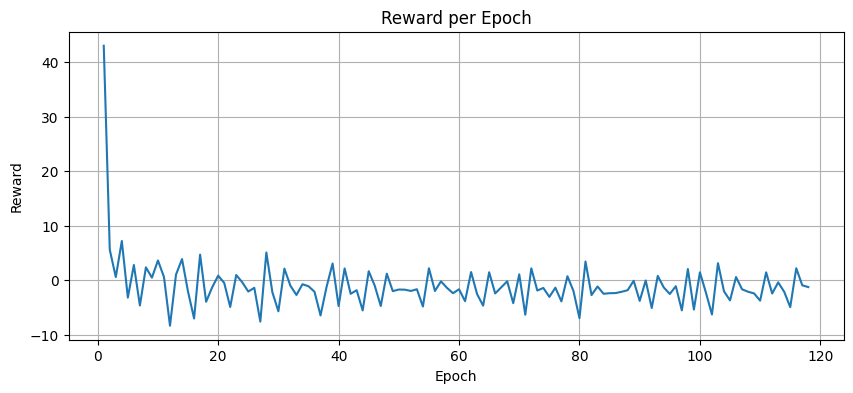

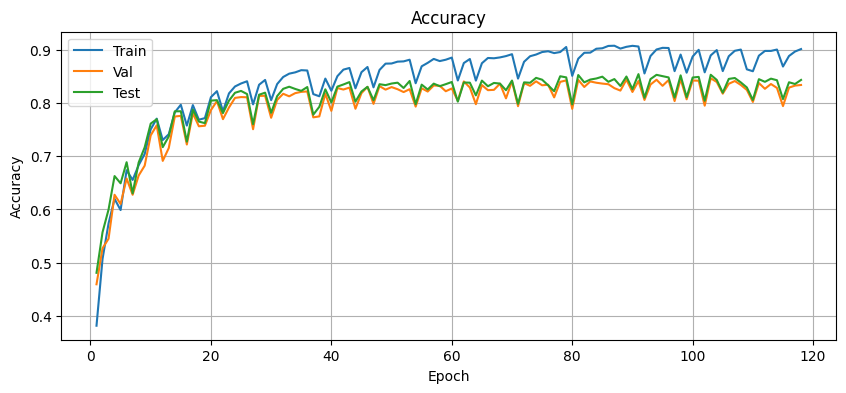

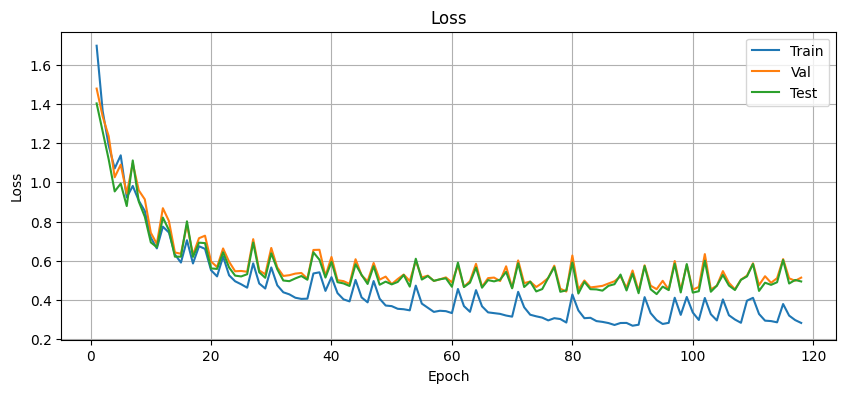

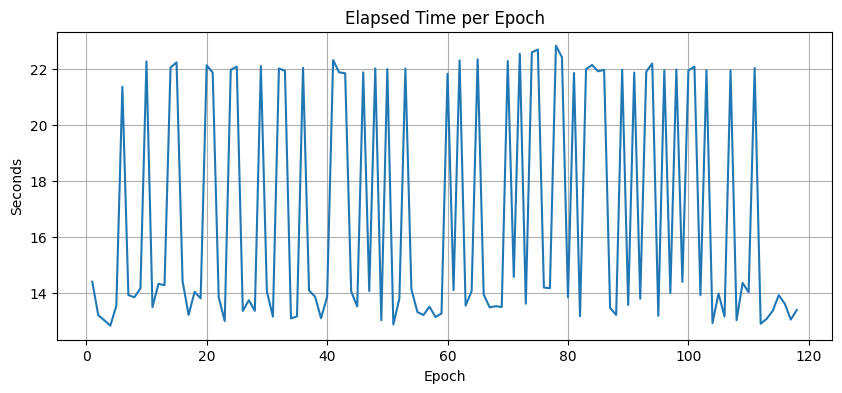

In [11]:
# 0) Giả sử mọi hàm / lớp (load_cifar10, get_resnet18_scratch,
#    OptimizerRLTrainer, …) đã được định nghĩa ở trên.

# 1) Tải dữ liệu
dl_train, dl_val, dl_test = load_cifar10()

# 2) Tạo mô hình ResNet-18 “scratch”
model = get_resnet18_scratch()        # ← TẠO model trước

# 3) Khởi tạo Trainer và huấn luyện
trainer = OptimizerRLTrainer(
    model,
    dl_train,
    dl_val,
    dl_test,
    n_epochs=150,
    patience=15
)
trainer.fit()                         # in log từng epoch

# 4) Báo cáo & vẽ biểu đồ
import pandas as pd
import matplotlib.pyplot as plt

reward_df = pd.DataFrame({
    "Epoch": range(1, len(trainer.hist["reward"]) + 1),
    "Reward": trainer.hist["reward"],
})
print("\n===== REWARD TABLE =====")
print(reward_df.to_string(index=False))

full_df = pd.DataFrame(trainer.hist).rename(columns={"time": "Time(s)"})
full_df.index = full_df.index + 1
full_df.index.name = "Epoch"
print("\n===== FULL METRICS TABLE =====")
print(full_df.to_string())

epochs = range(1, len(trainer.hist["train_acc"]) + 1)

# Reward plot
plt.figure(figsize=(10, 4))
plt.plot(reward_df["Epoch"], reward_df["Reward"])
plt.title("Reward per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Reward"); plt.grid(True); plt.show()

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, trainer.hist["train_acc"], label="Train")
plt.plot(epochs, trainer.hist["val_acc"],   label="Val")
plt.plot(epochs, trainer.hist["test_acc"],  label="Test")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, trainer.hist["train_loss"], label="Train")
plt.plot(epochs, trainer.hist["val_loss"],   label="Val")
plt.plot(epochs, trainer.hist["test_loss"],  label="Test")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

# Time plot (nếu đã lưu self.hist['time'])
if "time" in trainer.hist:
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, trainer.hist["time"])
    plt.title("Elapsed Time per Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.grid(True); plt.show()
